In [1]:
import torch
import torch.nn.functional as F

import torchsde
import math
import matplotlib.pyplot as plt

import numpy as np

from tqdm.notebook import tqdm

from torch import _vmap_internals

In [2]:
from cfollmer.objectives import log_g, relative_entropy_control_cost, stl_relative_entropy_control_cost
from cfollmer.sampler_utils import FollmerSDE, SimpleForwardNetBN
from cfollmer.trainers import basic_batched_trainer

# The Model

\begin{align}
\theta &\sim \mathcal{N}(\theta | 0, \sigma_w^2 \mathbb{I}) \\
y_i | x_i, \theta &\sim  \mathcal{N}(y | \theta^\top x_i + \theta_0, \sigma_y^2 \mathbb{I})
\end{align}

We want samples from $p(\theta | \{(y_i, x_i)\})$.

## Loading the StepFunc dataset

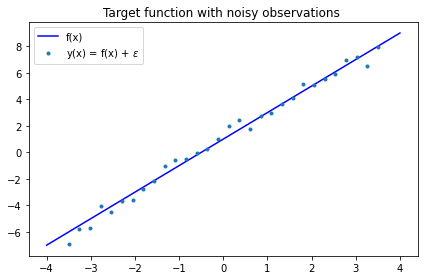

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

func = lambda x: 2* x + 1

# Test inputs
num_test_samples = 30
X_test = np.linspace(-4, 4, num_test_samples).reshape(num_test_samples,1)

# Noise free training inputs
X_train = np.linspace(-3.5, 3.5, 30).reshape(-1,1)
#f_train = np.cos(X_train) 
f_train = func(X_train)

# Noise-free training outputs
#f = np.cos(X_test)
f = func(X_test)
y_test  = f

# Noisy training Inputs with additive Gaussian noise (zero-mean, variance sigma_n)
sigma_n = 0.5

mu = np.zeros(X_train.size)
epsilon = np.random.multivariate_normal(mu, sigma_n**2 * np.eye(X_train.size))

# Noisy targets
y_train = f_train + epsilon.reshape(X_train.size,1)

# Noisy observations
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
ax.plot(X_test, f, 'b', label = 'f(x)')
ax.plot(X_train, y_train,".",  label = 'y(x) = f(x) + $\epsilon$')
ax.legend(loc = 'upper left')
ax.set_title('Target function with noisy observations ')

plt.show()

In [4]:
X_train.shape, f_train.shape

((30, 1), (30, 1))

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"



X_train, X_test, y_train, y_test = \
    torch.tensor(X_train, dtype=torch.float32, device=device), \
    torch.tensor(X_test, dtype=torch.float32, device=device), \
    torch.tensor(y_train, dtype=torch.float32, device=device), \
    torch.tensor(y_test, dtype=torch.float32, device=device) 

$$\DeclareMathOperator*{\argmin}{arg\,min}$$
$$\def\E{{\mathbb{E}}}$$
$$\def\rvu{{\mathbf{u}}}$$
$$\def\rvTheta{{\bm{\Theta}}}$$
$$\def\gU{{\mathcal{U}}}$$
$$\def\mX{{\mathbf{X}}}$$

## Controlled Schrodinger Follmer Sampler

The objevtive we are trying to implement is:

\begin{align}
  \mathbf{u}_t^{*}=  \argmin_{\rvu_t \in \mathcal{U}}\mathbb{E}\left[\frac{1}{2\gamma}\int_0^1||\rvu(t, \Theta_t)||^2 dt - \ln\left(\frac{ p(\mX | \Theta_1)p(\Theta_1)}{\mathcal{N}(\Theta_1|\mathbf{0}, \gamma \mathbb{I} )}\right)\right] \
\end{align}

Where:
\begin{align}
d\Theta_t = \rvu(t, \Theta_t)dt + \sqrt{\gamma} dB_t
\end{align}


In [6]:
import torch.nn.functional as F


class OnedRegressionForwardNet(object):
    
    def __init__(
        self, input_dim=1, output_dim=1, depth=None,
        width=20, width_seq=None, device="cpu", activation=F.relu
    ):
        
        self.device = device
        self.output_dim = output_dim
        self.input_dim = input_dim 
        self.activation = activation
        self.shapes = []
        
        self.depth = depth
        if not self.depth:
            self.depth = 1
        if not width_seq and self.depth > -1:
            self.width = width
            self.width_seq = [self.width] * (self.depth + 1)
            self.shapes = [(self.width_seq[i-1], self.width_seq[i])  for i in range(1,self.depth)]
            self.shapes += [(self.width_seq[-1], self.output_dim)]
            self.shapes = [(self.input_dim, self.width_seq[0])] + self.shapes
            
        
        self.dim = sum([wx * wy + wy for wx, wy in self.shapes]) if self.depth > -1 else self.input_dim + 1
        
        
    def forward(self, x, Θ):
        index = 0
        n, d = x.shape

#         Θ = (Θ - Θ.mean()) / Θ.std()

        for wx, wy in self.shapes[:-1]:
            x = F.linear(
                x,
                Θ[index: index + wx * wy].reshape(wy, wx),
                Θ[index + wx * wy: index + wx * wy + wy].reshape(1,wy)
            )
            x = self.activation(x)
            index += wx * wy  + wy
#         import pdb; pdb.set_trace()
        wx, wy = self.shapes[-1] if self.shapes else (self.input_dim, self.output_dim)
#         import pdb; pdb.set_trace()
        x = F.linear(
            x,
            Θ[index: index + wx * wy].reshape(wy, wx),
            Θ[index + wx * wy: index + wx * wy + wy].reshape(1,wy)
        )
        return x.to(self.device)
    
    def map_forward(self, x, Θ):
        preds_func = lambda θ: self.forward(x, θ)
        batched_preds = torch._vmap_internals.vmap(preds_func)
        preds = torch.hstack(list(map(preds_func, Θ)))
        return preds
        

In [7]:
net = OnedRegressionForwardNet(
    1,1, device=device, depth=-1, width=1, activation=F.relu
)

def ln_prior(Θ, σ_w=1.5):
    """
    Logistic regresion bayesian prior
    """
    return -0.5 * (Θ**2).sum(axis=1) / σ_w**2 


def log_likelihood_vmap(Θ, X, y, net=net, σ_y=0.5):
    """
    Hoping this implementation is less buggy / faster
    
    still feels a bit slow.
    """
    preds_func = lambda θ: net.forward(X, θ)
#     batched_preds = torch._vmap_internals.vmap(preds_func)
#     import pdb; pdb.set_trace()
    preds = torch.hstack(list(map(preds_func, Θ)))

    diff = preds - y
#     import pdb; pdb.set_trace()
    diff_sq_fld = -0.5 * (diff**2).sum(dim=0) / σ_y**2

    return diff_sq_fld

In [8]:
# def basic_batched_trainer(
#         γ, Δt, ln_prior, log_likelihood_vmap, dim, X_train, y_train=y_train,
#         method="euler", stl=True, adjoint=False, optimizer=None,
#         num_steps=200, batch_size_data=None, batch_size_Θ=no_posterior_samples,
#         batchnorm=True, device=device
#     ):
#     γ = 0.5
#     Δt = 0.01

#     # γ = 1
#     # Δt = 0.05 - \sigma_w = 10-6
#     adjoint = False
#     stl = True

#     t_size = int(math.ceil(1.0/Δt))
#     ts = torch.linspace(0, 1, t_size).to(device)
    
#     Θ_0 = torch.zeros((no_posterior_samples, net.dim)).to(device) 
    
#     sde = FollmerSDE(dim, dim, no_posterior_samples  , γ=γ, device=device).to(device)
#     optimizer = torch.optim.Adam(sde.μ.parameters(), lr=0.001, weight_decay =0.5)
#     #     optimizer = torch.optim.LBFGS(gpr.parameters(), lr=0.01)
#     losses = []
#     num_steps = 200
#     # with torch.autograd.set_detect_anomaly(True):
#     loss_ = stl_relative_entropy_control_cost if stl else relative_entropy_control_cost

#     for i in tqdm(range(num_steps)):
#         optimizer.zero_grad()

#         if isinstance(optimizer, torch.optim.LBFGS):
#             def closure():
#                 loss = loss_(
#                     sde, Θ_0.float(),
#                     X_train.float(), y_train.float(),
#                     ln_prior, log_likelihood_vmap, γ=γ,
#                     batchnorm=True, device=device
#                 )
#                 optimizer.zero_grad()
#                 loss.backward()
#                 return loss

#             optimizer.step(closure)
#             losses.append(closure().item())
#         else:
#             loss = loss_(
#                 sde, Θ_0,
#                 X_train, y_train,
#                 ln_prior, log_likelihood_vmap, γ=γ,
#                 batchnorm=False, device=device
#             )
#             optimizer.zero_grad()
#             loss.backward()

#             optimizer.step()       
#             losses.append(loss.item())
#         if stl:
#             sde.μ_detached.load_state_dict((sde.μ.state_dict()))
#     return sde, losses

In [21]:
lib_cal = True 



no_posterior_samples = 200
dim = net.dim
if not lib_cal:
    
    γ = 0.5
    Δt = 0.01

    # γ = 1
    # Δt = 0.05 - \sigma_w = 10-6
    adjoint = False
    stl = True

    t_size = int(math.ceil(1.0/Δt))
    ts = torch.linspace(0, 1, t_size).to(device)
    
    Θ_0 = torch.zeros((no_posterior_samples, net.dim)).to(device) 
    
    sde = FollmerSDE(dim, dim, no_posterior_samples  , γ=γ, device=device).to(device)
    optimizer = torch.optim.Adam(sde.μ.parameters(), lr=0.001, weight_decay =0.5)
    #     optimizer = torch.optim.LBFGS(gpr.parameters(), lr=0.01)
    losses = []
    num_steps = 200
    # with torch.autograd.set_detect_anomaly(True):
    loss_ = stl_relative_entropy_control_cost if stl else relative_entropy_control_cost

    for i in tqdm(range(num_steps)):
        optimizer.zero_grad()

        if isinstance(optimizer, torch.optim.LBFGS):
            def closure():
                loss = loss_(
                    sde, Θ_0.float(),
                    X_train.float(), y_train.float(),
                    ln_prior, log_likelihood_vmap, γ=γ,
                    batchnorm=True, device=device
                )
                optimizer.zero_grad()
                loss.backward()
                return loss

            optimizer.step(closure)
            losses.append(closure().item())
        else:
            loss = loss_(
                sde, Θ_0,
                X_train, y_train,
                ln_prior, log_likelihood_vmap, γ=γ,
                batchnorm=False, device=device
            )
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()       
            losses.append(loss.item())
        if stl:
            sde.μ_detached.load_state_dict((sde.μ.state_dict()))
        

else:
    γ = 0.5
    Δt = 0.01

    sde, losses = basic_batched_trainer(
        γ, Δt, ln_prior, log_likelihood_vmap, net.dim, X_train, y_train=y_train,
        method="euler", stl=True, adjoint=False, optimizer=None,
        num_steps=200, batch_size_data=None, batch_size_Θ=50,
        batchnorm=True, device=device
    )

  0%|          | 0/200 [00:00<?, ?it/s]

In [22]:
torch.cuda.empty_cache()

In [23]:
losses

[1409.18359375,
 1440.1986083984375,
 1442.1065673828125,
 1420.796630859375,
 1249.533935546875,
 1433.921875,
 1462.4376220703125,
 1294.052490234375,
 1323.7796630859375,
 1423.9532470703125,
 1474.2962646484375,
 1375.93994140625,
 1381.7926025390625,
 1374.9761962890625,
 1359.2027587890625,
 1293.846435546875,
 1389.3758544921875,
 1271.9664306640625,
 1310.9884033203125,
 1198.90478515625,
 1459.2913818359375,
 1264.089599609375,
 1293.7630615234375,
 1210.095458984375,
 1375.3665771484375,
 1302.242919921875,
 1231.721435546875,
 1322.774658203125,
 1201.2047119140625,
 1307.6751708984375,
 1255.6832275390625,
 1101.791748046875,
 1421.7901611328125,
 1322.7374267578125,
 1082.5528564453125,
 1290.7894287109375,
 1241.1666259765625,
 1301.378662109375,
 1151.3599853515625,
 1248.007568359375,
 1131.135498046875,
 1157.591064453125,
 1100.255615234375,
 1143.69189453125,
 1228.738525390625,
 1155.0537109375,
 1090.6680908203125,
 1235.468994140625,
 1127.3043212890625,
 989.5986

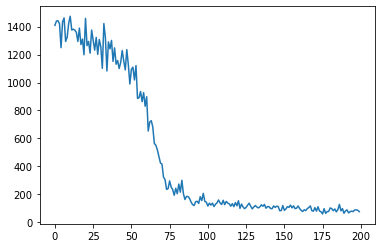

In [24]:
plt.plot(losses[:])

In [25]:
Θ_0 = torch.zeros((no_posterior_samples, net.dim)).to(device) 
t_size = int(math.ceil(1.0/Δt))
ts = torch.linspace(0, 1, t_size).to(device)

torch.cuda.empty_cache()


Θ_1 = torchsde.sdeint(sde, Θ_0, ts, dt=Δt)[-1,...]

(array([10., 15., 28., 43., 41., 29., 22.,  7.,  4.,  1.]),
 array([-0.19058286,  0.09389585,  0.37837455,  0.66285324,  0.94733196,
         1.2318107 ,  1.5162894 ,  1.800768  ,  2.0852468 ,  2.3697255 ,
         2.6542041 ], dtype=float32),
 <a list of 10 Patch objects>)

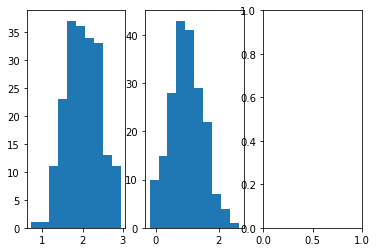

In [26]:
torch.cuda.empty_cache()
fig, (ax1,ax2,ax3) = plt.subplots(1,3)

ax1.hist(Θ_1[:,0].cpu().detach().numpy())
ax2.hist(Θ_1[:,1].cpu().detach().numpy())
# ax3.hist(Θ_1[:,-23].cpu().detach().numpy())

In [27]:
# pred = net.map_forward(X_train, Θ_1.mean(dim=0).reshape(1,-1))#.mean(axis=1)
end = 6.5
X_train_2 = torch.linspace(-end, end, 100).reshape(-1,1).to(device)

pred_ = net.map_forward(X_train_2, Θ_1)
pred = pred_.mean(axis=1)

σ  = pred_.std(axis=1)

C:\Users\vargf\AppData\Local\Temp/ipykernel_34524/4055719056.py:57: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  batched_preds = torch._vmap_internals.vmap(preds_func)


In [28]:
σ.shape, pred.shape

(torch.Size([100]), torch.Size([100]))

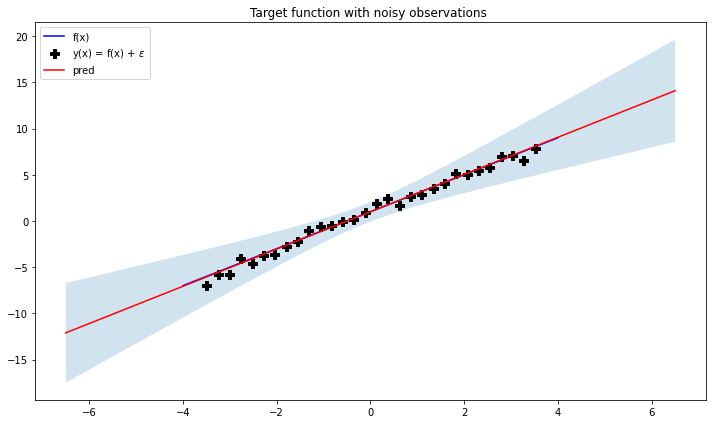

In [29]:
fig, ax = plt.subplots(figsize=(10, 6), tight_layout=True)
ax.plot(X_test.detach().cpu(), f, 'b', label = 'f(x)')
ax.plot(X_train.detach().cpu(), y_train.detach().cpu(), 'kP', ms = 9, label = 'y(x) = f(x) + $\epsilon$')
ax.plot(X_train_2.detach().cpu(), pred.detach().cpu(), color="red", label="pred")

σ_p , σ_m = (pred-2*σ).detach().cpu().numpy(), (pred+2*σ).detach().cpu().numpy()
ax.fill_between(X_train_2.detach().cpu().flatten(), σ_p.flatten() , σ_m.flatten(), alpha=.2)
ax.legend(loc = 'upper left')
ax.set_title('Target function with noisy observations ')

plt.show()

Text(0.5, 1.0, 'Sampled Posterior Weights')

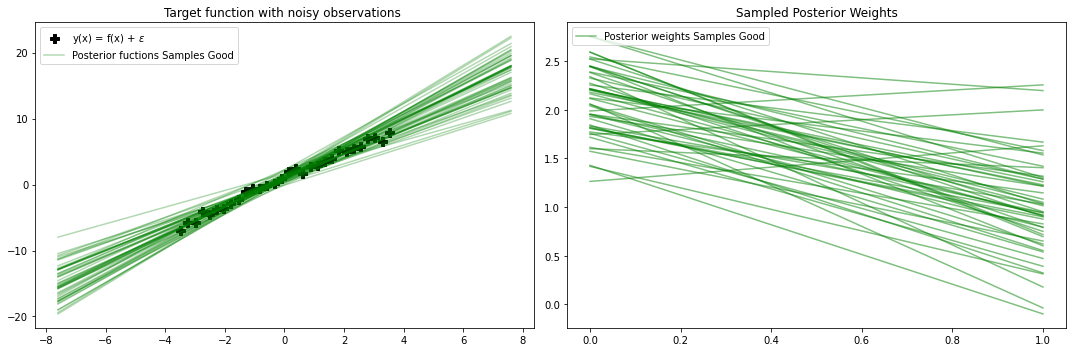

In [30]:

fig, (ax, ax1) = plt.subplots(1,2, figsize=(15, 5), tight_layout=True)
# ax.plot(X_test.detach().cpu(), f, 'b', label = 'f(x)')
ax.plot(X_train.detach().cpu(), y_train.detach().cpu(), 'kP', ms = 9, label = 'y(x) = f(x) + $\epsilon$')
# ax.plot(X_train.detach().cpu(), pred.detach().cpu(), color="red", label="pred")


zero_ind = torch.abs(X_train).argmin()

thresh = 10
label_2, label_1 = True, True

end=7.6
X_train_2 = torch.linspace(-end, end, 100).reshape(-1,1).to(device)

for i in range(50):
#     print(Θ_1[i,:3])
    θ = Θ_1[i,:,]
    pred = net.forward(X_train_2, θ).mean(axis=1)
    pred_min, pred_max = pred[zero_ind-thresh], pred[zero_ind+thresh]
    label = True if i==0 else False
    if torch.abs(pred_min - pred_max) < 0.25:
        ax.plot(
            X_train_2.detach().cpu(), pred.detach().cpu(),
            alpha=0.3, color="red", label="Posterior function Samples Flat" if label_1 else None
        )
        ax1.plot(θ.detach().cpu(),  alpha=0.5, color="red", label="Posterior weights Samples Flat"  if label_1 else None)
        label_1 = False
    else:
        ax.plot(
            X_train_2.detach().cpu(), pred.detach().cpu(),
            alpha=0.3, color="green", label="Posterior fuctions Samples Good" if label_2 else None
        )
        ax1.plot(θ.detach().cpu(),  alpha=0.5, color="green", label="Posterior weights Samples Good" if label_2 else None )
        label_2 = False 
        
        
ax.legend(loc = 'upper left')
ax.set_title('Target function with noisy observations ')

ax1.legend(loc = 'upper left')
ax1.set_title('Sampled Posterior Weights')
# plt.plot(X_train.detach().cpu(), y_train.detach().cpu())

